# Disease Spread Simulation

## Summary
This model simulates the process of epidemic disease spread. In particular, it raises the problem of **herd immunity**, which is a form of defence against epidemic diseases, which protects people that can't (or won't) be vaccinated, because when the majority of population is vaccinated (immune), then the disease can't spread.

The greater the proportion of immune ones (either in natural way or vaccinated), the lower the chance that those endangered will have contact with the disease. In case of, for example measles or smallpox, the *herd immunity threshold* is estimated to be 92-95% for the first one and 80-86% for the latter.  
The contact with infected person is necessary for these diseases to spread.

The model performs a simulation of a hypothetical disease, that can be spread by contact with infected ones.

__Sources__  
* Fine P., Eames K., Heymann D. L.. "Herd immunity": A rough guide. „Clinical Infectious Diseases”. 52 (7), s. 911–6, April 2011. https://academic.oup.com/cid/article/52/7/911/299077
* https://ourworldindata.org/vaccination#how-vaccines-work-herd-immunity-and-reasons-for-caring-about-broad-vaccination-coverage

## Description

The model simulates how multiple heterogeneous agents move around a map. There are 3 types of agents:
1. vaccinated [green]
2. unvaccinated [blue]
3. infected [red]

Firstly, individuals' coordinates are generated, according to provided information about number of infected and vaccinated. During each iteration, individuals change their position on the map.  
At a new location, if infected one will be within a provided distance from not infected ones, it will have a chance (small in case of vaccinated, and high in case of unvaccinated ones) to spread the disease.  
In reality, even vaccinated people have very small chance to catch the disease.
After every iteration the map with current situation is generated, showing what percentage of the whole population is infected. All the maps are saved in the working directory.

## Functions

In [1]:
using Random, PyPlot, DataFrames, Distributions
import Distributions: Uniform 

In [2]:
function generate_data(population, square_side, perc_infected, perc_vaccinated, perc_unvaccinated)
    """
    Generates each individual's coordinates on a map.
    population - number of people
    square_side - defines map size
    perc_infected - % of population infected
    perc_vaccinated - % of population vaccinated
    perc_unvaccinated - % of population not vaccinated (or can't be)
    """
    perc_list = [perc_infected, perc_vaccinated, perc_unvaccinated]
    @assert sum(perc_list) == 1
    
    typy = ["infected", "vaccinated", "unvaccinated"]
    df = DataFrame(x = Float64[], y = Float64[], typ = String[])
    
    for (index, value) in enumerate(perc_list)
        n_people = Int(round(population*value))
        
        x = rand(Uniform(1, square_side), n_people)
        y = rand(Uniform(1, square_side), n_people)
        typ = typy[index]
        
        df_temp = DataFrame(x = x, y = y, typ = typ)
        df = join(df, df_temp, kind = :outer, on = intersect(names(df), names(df_temp)))
    end 
    
    return df
end

generate_data (generic function with 1 method)

In [3]:
function make_plot(df, Title="")#, podtytul="")
    """
    Makes map with data generated previously
    data - df created previously
    colors:
    infected - red
    vaccinated - green
    unvaccinated - blue
    """
    for person in unique(df[:typ])
        
        data = df[(df[:typ] .== person), :]
        
        if person == "infected"
            color = "red"
        elseif person == "vaccinated"
            color = "green"
        elseif person == "unvaccinated"
            color = "blue"
        end
        
        PyPlot.scatter(data.x, data.y, alpha=0.4, c=color)
    end
    title(Title)
end

make_plot (generic function with 2 methods)

In [4]:
function distance(x_axis_1, y_axis_1, x_axis_2, y_axis_2)
    """
    Calculates distance between 2 points (Pythagorean theorem)
    x_axis_1, y_axis_1 - coordinates of the first point
    x_axis_2, y_axis_2 - coordinates of the second point
    """
    a=abs(x_axis_1-x_axis_2)
    b=abs(y_axis_1-y_axis_2)

    c = sqrt(a^2 + b^2)
    return c
end

distance (generic function with 1 method)

In [5]:
function new_positions(df, square_side)
    """
    Gets new random positons for individuals
    """
    df.x = rand(Uniform(1, square_side), nrow(df))
    df.y = rand(Uniform(1, square_side), nrow(df))
    return df
end

new_positions (generic function with 1 method)

In [6]:
function simulation(
        population, square_side, perc_infected, perc_vaccinated, perc_unvaccinated,
        infection_distance, infection_prob_vaccinated, infection_prob_perc_unvaccinated, 
        simulation_time, when_stop)
    
    data = generate_data(
        population, 
        square_side, 
        perc_infected, 
        perc_vaccinated, 
        perc_unvaccinated)

    # loop over time
    for time in 1:simulation_time

        # number of infected / the whole population
        n_people = by(data, :typ, Sum = :typ => length)
        n_all = sum(n_people.Sum)
        n_infected = n_people[(n_people[:typ] .== "infected"), :Sum]
        
        info_beginning = string(n_infected[1])*" / "*string(n_all)

        title = "Start - time: "*string(time)*" | infected: "*info_beginning
        make_plot(data, title)

        plot_name="plot"*string(time)*"-beginning.png"
        savefig(plot_name)
        clf()

        # 2 sets: infected i not_infected
        not_infected = data[(data[:typ] .!= "infected"), :]
        infected = data[(data[:typ] .== "infected"), :]

        # loop over infected - because they may infect others
        for ch in 1:nrow(infected)
            # loop over not infected - because they may become infected
            for nch in 1:nrow(not_infected)

                # calculate distance between infected and others
                dist_between = distance(
                    infected.x[ch],
                    infected.y[ch],
                    not_infected.x[nch],
                    not_infected.y[nch])

                # if it's smaller than arbitrary set value (by us) - there is a chance for catching infection
                if (dist_between <= infection_distance) & (not_infected.typ[nch] != "infected")

                    # vaccinated have very small chance to catch infection
                    if not_infected.typ[nch] == "vaccinated"
                        not_infected.typ[nch] = rand() < infection_prob_vaccinated ? "infected" : "vaccinated"
                    # not vaccinated have great chance to catch infection
                    elseif not_infected.typ[nch] == "unvaccinated"
                        not_infected.typ[nch] = rand() < infection_prob_perc_unvaccinated ? "infected" : "unvaccinated"
                    end
                end
            end
        end

        # merging two tables
        data_after = join(not_infected, infected, kind = :outer, on = intersect(names(not_infected), names(infected)))

        # number of infected compared to the whole population
        n_people = by(data, :typ, Sum = :typ => length)
        n_all = sum(n_people.Sum)
        n_infected = n_people[(n_people[:typ] .== "infected"), :Sum]
        
        info_end = string(n_infected[1])*" / "*string(n_all)

        title = "End - time: "*string(time)*" | infected: "*info_end
        make_plot(data_after, title)

        plot_name="plot"*string(time)*"-end.png"
        savefig(plot_name)
        clf()
        
        # current situation
        infected_perc = n_infected[1]/n_all
        
        # returns map after last iteration
        if time == simulation_time
            end_state = make_plot(data_after, title)
            println("Percentage infected: "*string(infected_perc*100))
            return (end_state, infected_perc)
        end
        
        # if `when_stop` is set to some value, function stops when % of infected reaches this value
        if infected_perc >= when_stop
            println("Percentage infected ("*string(round(infected_perc*100), 1)*") is over threshold: "*string(when_stop*100)*"%."*" Iteration: "*string(time))
            end_state = make_plot(data_after, title)
            return (end_state, infected_perc)
        end
        
        data = new_positions(data_after, square_side)
        
    end
end

simulation (generic function with 1 method)

## Results

### 1st case

Percentage infected: 5.800000000000001
Percentage infected: 6.4
Percentage infected: 5.6000000000000005
Percentage infected: 6.2
Percentage infected: 3.5999999999999996
Percentage infected: 6.2
Percentage infected: 4.8
Percentage infected: 2.6
Percentage infected: 6.2
Percentage infected: 3.4000000000000004
Percentage infected: 5.0
Percentage infected: 5.0
Percentage infected: 4.3999999999999995
Percentage infected: 4.8
Percentage infected: 5.4
Percentage infected: 4.2
Percentage infected: 4.6
Percentage infected: 4.8
Percentage infected: 5.800000000000001
Percentage infected: 2.6


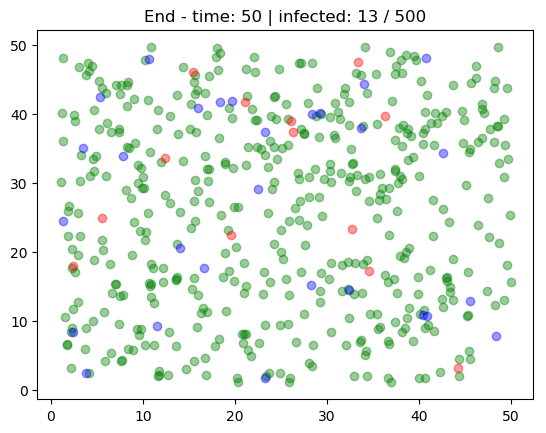

0.04870000000000001


In [8]:
res_1 = Float64[]

for i in 1:20
    
    result = simulation(
                    500,  # population
                    50,   # square_side
                    0.01, # perc_infected
                    0.92, # perc_vaccinated
                    0.07, # perc_unvaccinated
                    1,    # infection_distance
                    0.01, # infection_prob_vaccinated
                    0.8,  # infection_prob_unvaccinated
                    50,   # simulation_time
                    0.4)  # when_stop
    
    append!(res_1, result[2])
end

println(mean(res_1))

Percentage infected: 56.00000000000001
Percentage infected: 56.00000000000001
Percentage infected: 57.8
Percentage infected: 57.4
Percentage infected: 54.400000000000006
Percentage infected: 54.800000000000004
Percentage infected: 56.2
Percentage infected: 54.800000000000004
Percentage infected: 54.6
Percentage infected: 55.60000000000001
Percentage infected: 54.800000000000004
Percentage infected: 55.00000000000001
Percentage infected: 54.2
Percentage infected: 55.2
Percentage infected: 54.800000000000004
Percentage infected: 55.800000000000004
Percentage infected: 55.00000000000001
Percentage infected: 53.6
Percentage infected: 55.400000000000006

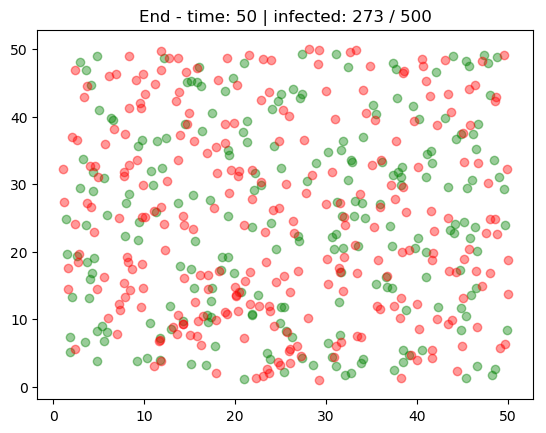


Percentage infected: 54.6
0.553


In [11]:
res_2 = Float64[]

for i in 1:20
    
    result = simulation(
                    500,  # population
                    50,   # square_side
                    0.01, # perc_infected
                    0.5,  # perc_vaccinated
                    0.49, # perc_unvaccinated
                    1,    # infection_distance
                    0.01, # infection_prob_vaccinated
                    0.8,  # infection_prob_unvaccinated
                    50,   # simulation_time
                    1)  # when_stop
    
    append!(res_2, result[2])
end

println(mean(res_2))

### 2nd case
To be continued...  
Does it support herd immunity threshold?...